### Importing Necessary Libraries

In [14]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [15]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 2.6.0+cu124
DEVICE: cuda


### Preparing Dataset

In [26]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomApply, RandomGrayscale, GaussianBlur, ToTensor
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch

# 1. Define the SimCLR-style transform
def get_complete_transform(output_shape, kernel_size, s=1.0):
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    transform = Compose([
        RandomResizedCrop(output_shape),
        RandomHorizontalFlip(p=0.5),
        RandomApply([color_jitter], p=0.8),
        RandomGrayscale(p=0.2),
        RandomApply([GaussianBlur(kernel_size=kernel_size)], p=0.5),
        ToTensor()
    ])
    return transform

# 2. Custom Dataset that returns 2 views of the same image
class SimCLRDataset(Dataset):
    def __init__(self, image_folder_dataset, transform):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.image_folder_dataset[index]  # Ignore label
        return self.transform(img), self.transform(img)

    def __len__(self):
        return len(self.image_folder_dataset)

# 3. Combine all train.X* folders into one dataset
def create_combined_train_dataset(base_path, output_shape=224, kernel_size=23):
    transform = get_complete_transform(output_shape, kernel_size)
    train_datasets = []

    for folder in sorted(os.listdir(base_path)):
        if folder.startswith("train.X"):
            full_path = os.path.join(base_path, folder)
            dataset = ImageFolder(full_path)
            train_datasets.append(SimCLRDataset(dataset, transform))

    combined_dataset = ConcatDataset(train_datasets)
    return combined_dataset

# 4. Validation dataset (usually not augmented like train, but can be)
def create_val_dataset(base_path, output_shape=224, kernel_size=23):
    transform = get_complete_transform(output_shape, kernel_size)  # You can use lighter transforms
    val_path = os.path.join(base_path, "val.X")
    val_dataset = ImageFolder(val_path)
    return SimCLRDataset(val_dataset, transform)

# 5. Create DataLoaders
base_path = "/kaggle/input/ssl-dataset/ssl_dataset"  # Root folder
BATCH_SIZE = 512

train_dataset = create_combined_train_dataset(base_path)
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

val_dataset = create_val_dataset(base_path)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Train dataset size: 130000
Validation dataset size: 5000


### Visualising Data

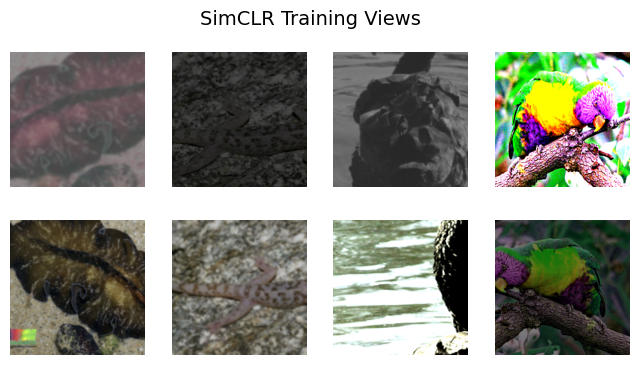

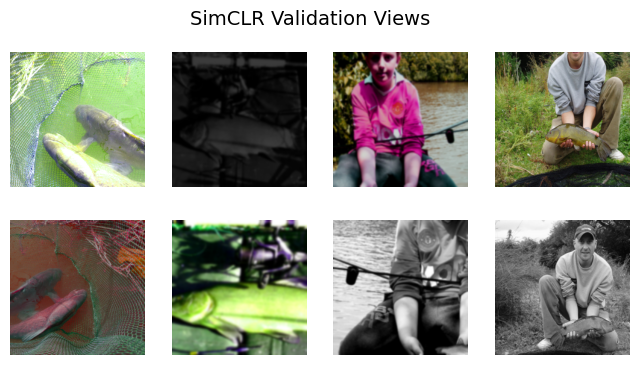

In [20]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Helper function to unnormalize and convert tensor to numpy image
def show_tensor_image(tensor_img):
    img = tensor_img.numpy().transpose(1, 2, 0)  # C, H, W -> H, W, C
    plt.imshow(img)
    plt.axis('off')

# Show n samples from a dataloader (either train_dl or val_dl)
def visualize_simclr_batch(dataloader, n=5, title=""):
    for batch in dataloader:
        view1, view2 = batch  # Each batch is a tuple of two views
        plt.figure(figsize=(2 * n, 4))

        for i in range(n):
            # Show view 1
            plt.subplot(2, n, i + 1)
            show_tensor_image(view1[i])
            if i == 0:
                plt.ylabel("View 1", fontsize=12)

            # Show view 2
            plt.subplot(2, n, i + 1 + n)
            show_tensor_image(view2[i])
            if i == 0:
                plt.ylabel("View 2", fontsize=12)

        plt.suptitle(title, fontsize=14)
        plt.show()
        break  # Only show one batch

# 👁️ Visualize some examples
visualize_simclr_batch(train_dl, n=4, title="SimCLR Training Views")
visualize_simclr_batch(val_dl, n=4, title="SimCLR Validation Views")


### SimCLR Model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math
import time
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar

# ----------- LARS Optimizer ------------
class LARS(torch.optim.Optimizer):
    def __init__(self, params, lr=0.1, momentum=0.9, weight_decay=1e-6, eta=0.001, eps=1e-9):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, eta=eta, eps=eps)
        super(LARS, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                d_p = p.grad

                if group["weight_decay"] != 0:
                    d_p = d_p.add(p, alpha=group["weight_decay"])

                if p.ndim != 1:
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(d_p)
                    if param_norm > 0 and update_norm > 0:
                        q = group["eta"] * param_norm / (update_norm + group["eps"])
                        d_p = d_p.mul(q)

                param_state = self.state[p]
                if "momentum_buffer" not in param_state:
                    buf = param_state["momentum_buffer"] = torch.clone(d_p).detach()
                else:
                    buf = param_state["momentum_buffer"]
                    buf.mul_(group["momentum"]).add_(d_p)

                p.add_(buf, alpha=-group["lr"])

# ----------- Identity Layer ------------
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

# ----------- SimCLR Model ------------
class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet50 = models.resnet50(weights=None)  # updated warning fix
        resnet50.fc = Identity()
        self.encoder = resnet50
        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256)
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)  # concatenate both views
        encoding = self.encoder(x)
        projection = self.projection(encoding)
        return projection

# ----------- NT-Xent Loss ------------
def nt_xent_loss(features, temperature):
    similarity_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)
    sim_matrix_exp = similarity_matrix / temperature

    mask = torch.eye(sim_matrix_exp.shape[0], dtype=torch.bool).to(features.device)
    sim_matrix_exp = sim_matrix_exp.masked_fill(mask, -9e15)

    positives = torch.cat([torch.diag(sim_matrix_exp, BATCH_SIZE), torch.diag(sim_matrix_exp, -BATCH_SIZE)]).view(2 * BATCH_SIZE, 1)
    negatives = sim_matrix_exp[~mask].view(2 * BATCH_SIZE, -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(features.device)
    return logits, labels

# ----------- Constants and Setup ------------
BATCH_SIZE = 1024
EPOCHS = 100
TEMP = 0.5
WARMUP_EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, scheduler
simclr_model = SimCLR().to(DEVICE)
base_lr = 0.3 * BATCH_SIZE / 256
optimizer = LARS(simclr_model.parameters(), lr=base_lr, weight_decay=1e-6)

def cosine_warmup_scheduler(epoch):
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / WARMUP_EPOCHS
    else:
        progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda=cosine_warmup_scheduler)
criterion = nn.CrossEntropyLoss()

# ----------- Training Loop ------------
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    simclr_model.train()

    for i, views in enumerate(tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        views = [v.to(DEVICE) for v in views]
        projections = simclr_model(views)
        logits, labels = nt_xent_loss(projections, TEMP)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_dl)
    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Time: {(time.time()-t0)/60:.2f} mins")


Epoch 1/100:   0%|          | 0/253 [00:26<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.06 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.45 GiB is free. Process 3576 has 12.29 GiB memory in use. Of the allocated memory 12.16 GiB is allocated by PyTorch, and 13.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)